<a href="https://colab.research.google.com/github/varshil009/Youtube-Comment-Sections-Analysis/blob/main/YOUTUBE_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.0 MB/s eta 0:00:00


In [89]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 674.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
import pandas as pd
import numpy as np

import regex # re2 for faster matching and replacing or removing
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

import torch
from transformers import AutoModel, AutoTokenizer

import hdbscan

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.cluster import KMeans

In [79]:
df = pd.read_csv(r"/content/comments_data (2).csv")

In [80]:
df.head()

,CommentID,Timestamp,Username,Comment,Date,Likes,reply_comment_id,replies
0,UgwMHWZVtOEnS1zrhol4AaABAg,2025-03-09T07:01:30Z,@starlakes,i saw this video and said “frick no. that shi ...,2025-03-09T07:01:30Z,0,NaN,NaN
1,UgyDB1A1XJDPNP0K0KF4AaABAg,2025-03-09T07:01:22Z,@Abdullahnauman245,what if your planes battery dies because the w...,2025-03-09T07:01:22Z,0,NaN,NaN
2,UgxW8RF3D75vDX-s0gV4AaABAg,2025-03-08T17:08:41Z,@polska905,Battery tech is not ready for airplanes or hig...,2025-03-08T17:08:41Z,0,NaN,NaN
3,UgwyaExcfioNwR0E5XN4AaABAg,2025-03-08T16:40:23Z,@BojanBojovic,"One day, looking back to burning fossils to mo...",2025-03-08T16:40:23Z,0,NaN,NaN
4,Ugy0ZiLwDdKhFIT51I54AaABAg,2025-03-08T13:51:40Z,@-0zone492,how about putting 25 seat only so that the pla...,2025-03-08T13:51:40Z,0,NaN,NaN


In [81]:
df.shape

(452, 8)

In [66]:

def sent_process(sent):
    words = sent.split()
    for i, word in enumerate(words):
        # Remove various types of URLs
        word = word.lower()
        word = regex.sub(r'\p{Emoji}', lambda m: emoji.demojize(m.group()), word)
        word = regex.sub(r'@+[A-Za-z0-9_]+(\s|$)', '', word)  # rplace usernames from the comments
        word = regex.sub(r'https?://\S+', '', word)  # Remove HTTP/HTTPS links
        word = regex.sub(r'[^a-zA-Z0-9\s]', ' ', word)
        words[i] = word.strip()

    return " ".join(words)

def text_process(df):
    df['cleaned_parent_comm'] = [sent_process(x) for x in df.Comment]
    #df['cleaned_replies'] = [" || ".join([sent_process(y) for y in x.split(" || ") if x else np.nan]) for x in df.replies]

    df['cleaned_replies'] = df['replies'].apply(
        lambda x: " || ".join([sent_process(y) for y in x.split(" || ")]) if pd.notna(x) else np.nan
    )

    return df

df = text_process(df)

### 3 types of data we need :
#### 1. all comments ==> topic modelling for top discussed topics
#### 2. all comments ==> sentiment analysis
#### 3. top 5 comments and replies ==> summarization

In [68]:
all_text = list(df.cleaned_parent_comm) +  list(df.cleaned_replies)

In [69]:
top_comments_df = df.sort_values(by = 'Likes', ascending = False).reset_index()
top_comments_df.head()

,index,CommentID,Timestamp,Username,Comment,Date,Likes,reply_comment_id,replies,cleaned_parent_comm,cleaned_replies
0,356,UgxcWYFTQQFts-iUpn94AaABAg,2025-03-02T07:51:22Z,@_zinu,"To solve middle distance mobility, we don't ne...",2025-03-02T07:51:22Z,825,|| Ugyud2WSXogNFZJReIl4AaABAg || UgzRixxenWe-...,|| Would it help the plane to have an alterna...,to solve middle distance mobility we don t nee...,|| would it help the plane to have an alterna...
1,399,Ugz_s2DdzxEvKyiel9R4AaABAg,2025-03-02T05:51:20Z,@N0Xa880iUL,For the distances of 200-600km we need electri...,2025-03-02T05:51:20Z,546,|| UgzXJ0GqH2cSa24Fhvp4AaABAg || Ugx25YyxslhF...,|| This video was really insightful and exper...,for the distances of 200 600km we need electri...,|| this video was really insightful and exper...
2,357,UgyWQb4u-88BvEIg8pR4AaABAg,2025-03-02T07:42:05Z,@marcusellby,"In Stockholm, Sweden, we ha an electric hydrof...",2025-03-02T07:42:05Z,230,|| UgwGVWxFSv-hhsI8Tpd4AaABAg || UgxvOCAAjC-N...,|| Does this system utilize a Li-on or Lipo b...,in stockholm sweden we ha an electric hydrofoi...,|| does this system utilize a li on or lipo b...
3,427,UgwC0sNXDRrNe2iQAT94AaABAg,2025-03-02T05:14:06Z,@jonathanmoynihan3661,All these innovarions are cool but gimmicks. B...,2025-03-02T05:14:06Z,159,|| UgxuwsKKUcuYNNxr1VV4AaABAg.AFCyjxEyPDyAFEe...,|| @@berkeliumk :) || Didn't expect to see Kr...,all these innovarions are cool but gimmicks ba...,|| || didn t expect to see kryton at the en...
4,327,UgzaWKu-au7lwDIici14AaABAg,2025-03-02T09:24:40Z,@vuxanov,Can’t wait to take 3d printed hyper-loop to gr...,2025-03-02T09:24:40Z,142,|| Ugw8zAypTCrlYFUr6xR4AaABAg || UgxM3sjuv58N...,|| Hogwash || Why not to use the flotation an...,can t wait to take 3d printed hyper loop to gr...,|| hogwash || why not to use the flotation an...


In [70]:
top_comments = []
for i in range(5):
    dic = {}
    dic['comment'] = top_comments_df.loc[i, "cleaned_parent_comm"]
    dic['replies'] = top_comments_df.loc[i, "cleaned_replies"]
    dic['likes'] = top_comments_df.loc[i, "Likes"]
    top_comments.append(dic)
top_comments[0]

{'comment': 'to solve middle distance mobility we don t need new fancy tech we need better train and cycling infrastructure',
 'replies': ' || would it help the plane to have an alternator attached to the fuel based engines to help charge the batteries we do that with cars just wondering if it can be repurposed || interesting || why spend fuel and payload to carry batteries these are toys think of how much energy there is in a gallon of jet a at 6 8 pounds now think of how many pounds of battery you need to equal that much energy this is a dream || wait kryten from red dwarf is the founder of fully charged || so you are going to burn jet fuel transporting heavy batteries  electric motors || why don t we get cold fusion the energy discovery from 1989 from pons and fleischmann to work by investing in it and then power the planes boats with cold fusion || this is the new age of cold fusion with the death of usaid the videos topics will change from us propaganda to stock pumping ads for co

In [14]:
len(top_comments)

5

### WE HAVE DATA NOW

### TOPIC MODELLING DOESNT CARE ABOUT THE START AND END OF SENTENCE SINCE IT USES BAG OF WORDS FOR MODELLING T`OPICS

In [48]:
if np.nan: print(True)

True


In [83]:
all_text[-3]

' ||  except in japan     beaming face with smiling eyes   i guarantee your experience would be different ||  that s state level and state funded i m discussing the federal government different system i wish our infrastructure and culture aligned more with europe s approach to mass transportation ||  what did i miss ah yes present data show that evs catch fire far less frequently per mile driven than do ice vehicles and ev fires are becoming even more rare as batteries improve more and more batteries being lfp rather than ncm chemistry for example lfps don t have the same fire issues and it s incorrect to suggest that energy density of batteries won t continue to rapidly increase it s quadrupled in the last couple of decades and advances continue now that range is sufficient a greater portion of additional improvements will go toward reducing price rather than toward increasing the range || almost at 5 mill subs o || what we need is electric propellerless planes jetoptera || why should

In [86]:
all_text_unsplitted = []

for sent in all_text:
    if type(sent) == float: continue

    if " || " in sent:
        sent = sent.split(" || ")
        for s in sent:
            all_text_unsplitted.append(s)
    else:
        all_text_unsplitted.append(sent)

cleaned_all_text = []
for sent in all_text_unsplitted:
    if type(sent) == float: continue

    # Tokenize the text
    words = word_tokenize(sent)  # Convert to lowercase for consistency

    # Get English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Join words back into a sentence
    cleaned_all_text.append(" ".join(filtered_words))

In [87]:
len(cleaned_all_text)

920

In [90]:
from bertopic import BERTopic

# Initialize and train BERTopic
topic_model = BERTopic()

In [93]:
topic_model.save("BERTopic")
files.download("BERTopic")

2025-03-09 13:51:15,314 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
topics, probs = topic_model.fit_transform(cleaned_all_text)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [95]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,151,-1_energy_battery_weight_fuel,"[energy, battery, weight, fuel, batteries, ele...",[concerned weight want hybrid since energy den...
1,0,179,0_face_rolling_laughing_floor,"[face, rolling, laughing, floor, video, tone, ...","[rolling floor laughing, face tears joy rollin..."
2,1,131,1_trains_train_city_need,"[trains, train, city, need, infrastructure, pe...",[feels like square peg round hole problem othe...
3,2,75,2_planes_battery_electric_plane,"[planes, battery, electric, plane, would, batt...",[much enjoy advancements planes things like el...
4,3,69,3_fossil_cars_emissions_electricity,"[fossil, cars, emissions, electricity, electri...",[electric cars crashing sales soon virtually d...
5,4,48,4_nope_interested_sorry_never,"[nope, interested, sorry, never, yep, done, ag...","[already done long ago, nope interested sorry,..."
6,5,31,5_technology_batteries_battery_nuclear,"[technology, batteries, battery, nuclear, bett...",[battery technology perhaps nuclear battery te...
7,6,31,6_boats_electric_boat_ferries,"[boats, electric, boat, ferries, fusion, total...",[really think electric boats underutilised ide...
8,7,29,7_electric_crash_plane_scam,"[electric, crash, plane, scam, lol, planes, ai...","[build plane wont crash crash survivable, pipi..."
9,8,28,8_fire_lithium_risk_battery,"[fire, lithium, risk, battery, landing, plane,...",[fire risk airlines banning power banks fire h...


In [96]:
df = topic_model.get_topic_info()
df.Representation[:5]

,Representation
0,"[energy, battery, weight, fuel, batteries, ele..."
1,"[face, rolling, laughing, floor, video, tone, ..."
2,"[trains, train, city, need, infrastructure, pe..."
3,"[planes, battery, electric, plane, would, batt..."
4,"[fossil, cars, emissions, electricity, electri..."


In [99]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [113]:
# Load RoBERTa-based sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [115]:
# Function to predict sentiment (Negative, Neutral, Positive)
def predict_sentiment(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    sentiment_class = torch.argmax(probabilities).item()

    sentiment_labels = [-1, 0, 1]
    return sentiment_labels[sentiment_class]


sentiments = []
for i, text in enumerate(all_text_unsplitted):
    if i % 50 == 0: print(i)
    if text:
        sentiments.append(predict_sentiment(text))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


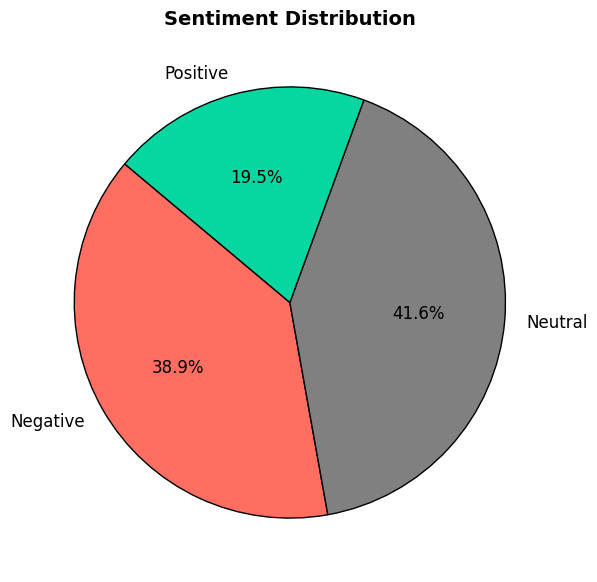

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Count occurrences of each sentiment
sentiment_counts = { -1: sentiments.count(-1), 0: sentiments.count(0), 1: sentiments.count(1) }

# Define labels and colors
labels = ["Negative", "Neutral", "Positive"]
colors = ["#FF6F61", "#808080", "#06D6A0"]  # Red, Yellow, Green

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts.values(), labels=labels, colors=colors, autopct="%1.1f%%", startangle=140,
        wedgeprops={"edgecolor": "black", "linewidth": 1}, textprops={"fontsize": 12})

# Title and styling
plt.title("Sentiment Distribution", fontsize=14, fontweight="bold")
plt.show()

In [135]:
from transformers import pipeline

summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


In [141]:
text = " ".join(top_comments[0]['replies'].split(" || ")[:10])

In [142]:
len(text)

1164

In [143]:
summary = summarizer(text, max_length=100, min_length=30, do_sample=False)

print(summary[0]['summary_text'])

 Would it help the plane to have an alternator attached to the fuel based engines to help charge the batteries we do that with cars with cars just wondering if it can be repurposed interesting why spend fuel and payload to carry batteries these are toys think of how much energy there is in a gallon of jet fuel .
